In [1]:
import sys
sys.path.append("../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# import seaborn as sns
# sns.set(rc={'figure.facecolor':'white'})
# plt.rcParams["figure.facecolor"] = "white"

%matplotlib inline

from analysis_helpers import savefig, load_data_by_session_id

from eye_tracking.eye_tracking import get_stim_at_frame, get_saccade_magnitude_direction
from experiment.cre_line import match_cre_line
from eye_plotting import STIM_ABBREV, STIM_COLORS

In [2]:
def set_major_minor_ticks(ax, window_radius, minor_tick_step=100, major_tick_step=500, center=0):
    window_radius_max = window_radius/30*1000
    minor_ticks = [0]
    while minor_ticks[-1] + minor_tick_step <= window_radius_max:
        tick = minor_ticks[-1] + minor_tick_step
        minor_ticks.insert(0, -tick)
        minor_ticks.append(tick)
    ax.set_xticks([ms/1000*30+center for ms in minor_ticks], minor=True)

    # MAJOR ticks every 500 ms
    major_ticks = [tick for tick in minor_ticks if tick % 500 == 0]
    ax.set_xticks([ms/1000*30+center for ms in major_ticks])
    ax.set_xticklabels(major_ticks, fontsize=14)

    ax.tick_params(axis="x", which="major", direction="out", length=6, width=1, color="black")
    ax.tick_params(axis="x", which="minor", direction="out", length=2, width=1, color="black")

In [3]:
def plot_heatmap_responses(data, cell_index, saccades, ax, window_radius=45, colorbar=True, fontsize=14, vmin=None, vmax=None):
    if len(saccades) == 0:
        return

    traces = []

    for ss, se in saccades:
        times = slice(ss-window_radius, ss+window_radius+1)
        trace = data["dff_traces"][cell_index, times]
        if len(trace) == 2*window_radius+1:
            traces.append(trace)
    
    # Color mesh plot
    if vmin is None: vmin = 0
    if vmax is None: vmax = np.percentile(traces, 99)
    cax = ax.pcolormesh(traces, cmap="magma", vmin=vmin, vmax=vmax)
    # if colorbar: cb = fig.colorbar(cax, pad=0.015, label="dF/F")

    set_major_minor_ticks(ax, window_radius, center=window_radius+0.5) # 0.5 center so it aligns at the center of the color cell

    # ax.set_xticklabels([ (x-window_radius)/30*1000 if x % 15 == 0 else None for x in xticks], fontsize=14)
    
    # No y-ticks
    # plt.yticks(ticks=[], labels=[])
    # ax.set_yticks([])
    # ax.axis("off")
    # ax.set_title(f"Cell {cell_index}, $p = {p:.4f}$")

    ax.axvline(window_radius+0.5, color="white", linestyle="dashed")

    ax.set_ylabel("Saccade", fontsize=fontsize)
    ax.set_xlabel("Time relative to saccade onset (ms)", fontsize=fontsize)
    # ax.set_title(f"Saccade-triggered {type} averages ({len(cell_mean_traces)} cells, {len(saccades)} saccades)", fontsize=16)
    return vmin, vmax


def plot_saccade_stim_lines(saccades_stim, ax, x, linewidth=3, stim_labels=False):
    ymin = 0
    ymax = None
    for i in range(len(saccades_stim)):
        if i == len(saccades_stim) - 1:
            # This is the last saccade
            ymax = i+1
        elif saccades_stim[i+1][1] != saccades_stim[i][1]:
            # This is the last saccade of the same type as the ones before
            ymax = i+1
        
        if ymax is not None:
            stim = saccades_stim[i][1]
            color = STIM_COLORS[stim]
            ax.vlines(x=x, ymin=ymin, ymax=ymax, color=color, linewidth=linewidth, zorder=10)
            if stim_labels:
                mid = (ymin+ymax)/2
                ax.text(x-1, mid, stim, color=color, ha="right", va="center")
            ymin = ymax
            ymax = None

Session 606227591; Cell 662076627; Ntsr1; Ai148 VISp
Session 606227591; Cell 662076627; Ntsr1; Ai148 VISp


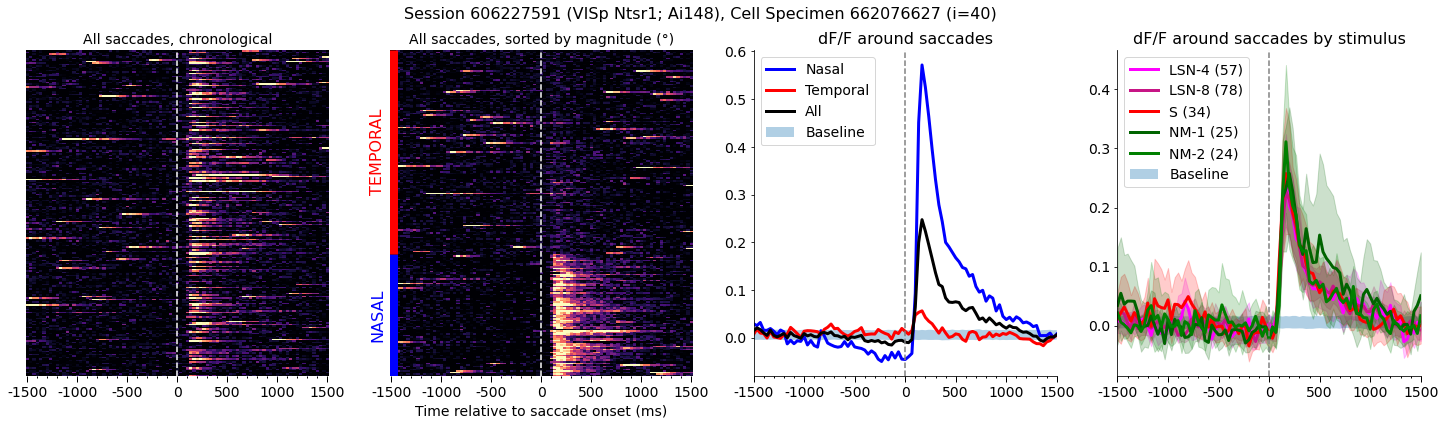

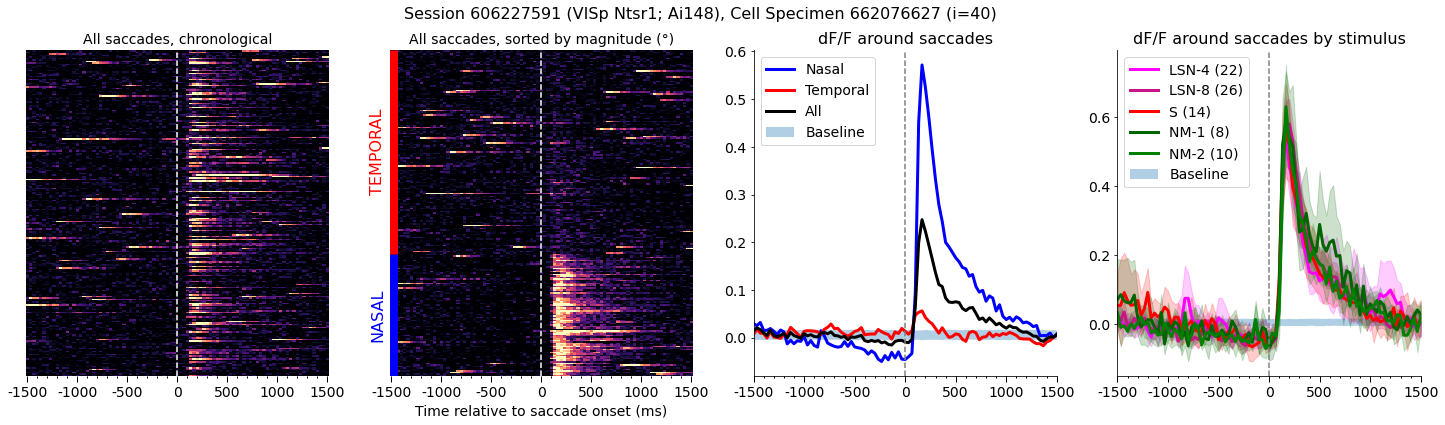

In [4]:
def plot_sample_activity(session_id, cell_index, window_radius=45, response_classification=None, ds=None):
    data = load_data_by_session_id(session_id)
    saccades = data["saccades"]
    eye_data = data["eye_tracking"]
    stim_epoch = data["stim_epoch"]

    fig, (ax_all, ax_sorted, ax_boot, ax_stim) = plt.subplots(ncols=4, figsize=(25, 6), facecolor="white")
    
    # All saccades
    vmin, vmax = plot_heatmap_responses(data, cell_index, list(reversed(saccades)), ax_all, window_radius=window_radius, colorbar=False)
    ax_all.set_title("All saccades, chronological", fontsize=14)
    # plot_saccade_stim_lines(saccades_stim, ax_all, (ax_all.get_xlim()[1]-1)/2)
    ax_all.set_xlabel("")
    ax_all.set_ylabel("")
    ax_all.set_yticks([])
    plt.setp(ax_all.spines.values(), visible=False)

    # Saccades sorted by magnitude
    nasal_sacc = sorted([s for s in saccades if get_saccade_magnitude_direction(eye_data, *s)[1] == "L"], key=lambda s: get_saccade_magnitude_direction(eye_data, *s)[1])
    temporal_sacc = sorted([s for s in saccades if get_saccade_magnitude_direction(eye_data, *s)[1] == "R"], key=lambda s: get_saccade_magnitude_direction(eye_data, *s)[1])
    plot_heatmap_responses(data, cell_index, nasal_sacc + temporal_sacc, ax_sorted, window_radius=window_radius, colorbar=False, vmin=vmin, vmax=vmax)
    xlim = ax_sorted.get_xlim()
    ax_sorted.vlines(x=xlim[0], ymin=0, ymax=len(nasal_sacc), color="blue", linewidth=15)
    ax_sorted.vlines(x=xlim[0], ymin=len(nasal_sacc), ymax=(len(nasal_sacc)+len(temporal_sacc)), color="red", linewidth=15)
    # nasal_label = f"NASAL\n{get_degrees_moved(eye_data, *nasal_sacc[0]):.2f}, {get_degrees_moved(eye_data, *nasal_sacc[len(nasal_sacc)//2]):.2f}, {get_degrees_moved(eye_data, *nasal_sacc[-1]):.2f}"
    # temporal_label = f"TEMPORAL\n{get_degrees_moved(eye_data, *temporal_sacc[0]):.2f}, {get_degrees_moved(eye_data, *temporal_sacc[len(temporal_sacc)//2]):.2f}, {get_degrees_moved(eye_data, *temporal_sacc[-1]):.2f}"
    nasal_label = "NASAL"
    temporal_label = "TEMPORAL"
    ax_sorted.text(xlim[0]-3.5, len(nasal_sacc)/2, nasal_label, fontsize=16, color="blue", ha="center", va="center", rotation=90)
    ax_sorted.text(xlim[0]-3.5, (2*len(nasal_sacc)+len(temporal_sacc))/2, temporal_label, fontsize=16, color="red", ha="center", va="center", rotation=90)
    ax_sorted.set_title("All saccades, sorted by magnitude (°)", fontsize=14)
    ax_sorted.set_ylabel("")
    ax_sorted.set_yticks([])
    ax_sorted.set_xlim(xlim)
    # ax_sorted.yaxis.set_visible(False)
    plt.setp(ax_sorted.spines.values(), visible=False)
    # ax_sorted.spines["left"].set_visible(False)

    # Bootstrapped distribution
    n_bootstrap = 1000
    boot_dist = np.zeros((n_bootstrap, 2*window_radius+1))
    boot_rand_min = boot_dist.shape[1]*5 # int(data["dff"].shape[1] * 0.01)
    boot_rand_max = data["dff_traces"].shape[1] - boot_rand_min

    for b in range(n_bootstrap):
        for i in range(len(saccades)):
            # Choose random saccade time
            ss = random.randint(boot_rand_min, boot_rand_max)
            trace = data["dff_traces"][cell_index, ss-window_radius:ss+window_radius+1]
            boot_dist[b] += trace / len(saccades)

    # n_sacc_boot = 200
    # sacc_boot_dist = np.zeros((n_sacc_boot, 2*window_radius+1))
    # for b in range(n_sacc_boot):
    #     for i in np.random.choice(len(saccades), n_sacc_boot):
    #         ss, se = saccades[i]
    #         trace = data["dff_traces"][cell_index, ss-window_radius:ss+window_radius+1]
    #         sacc_boot_dist[b] += trace / len(saccades)
    
    sacc_responses = []
    dirs = []
    for i, (ss, se) in enumerate(saccades):
        # TODO: validate that it starts when we have times
        trace = data["dff_traces"][cell_index, ss-window_radius:ss+window_radius+1]
        if len(trace) == 2*window_radius+1:
            sacc_responses.append(trace)
            mag, dir = get_saccade_magnitude_direction(eye_data, ss, se)
            dirs.append(dir)
    
    sacc_responses = np.array(sacc_responses)
    
    sacc_mean = sacc_responses.mean(axis=0)
    sacc_mean_nasal = sacc_responses[[i for i in range(len(sacc_responses)) if dirs[i] == "L"], :].mean(axis=0)
    sacc_mean_temporal = sacc_responses[[i for i in range(len(sacc_responses)) if dirs[i] == "R"], :].mean(axis=0)
    mid_95_quantile = [0.025, 0.975] # Middle 95%
    low_q, high_q = np.quantile(boot_dist, mid_95_quantile, axis=0)
    low_q_sacc, high_q_sacc = np.quantile(sacc_responses, mid_95_quantile, axis=0)
    boot_mean = boot_dist.mean(axis=0)

    # print(np.logical_or(np.median(sacc_responses, axis=0) < low_q, high_q < np.median(sacc_responses, axis=0)))

    x = np.arange(-window_radius, window_radius+1)

    set_major_minor_ticks(ax_boot, window_radius, center=0)

    # ax_boot.fill_between(x, *np.quantile(sacc_boot_dist, [0.25, 0.75], axis=0), color="green", alpha=0.35, label="Sacc mid 95%")
    # ax_boot.plot(x, np.mean(sacc_boot_dist, axis=0), color="green", linewidth=2, label="Sacc boot mean")

    # ax_boot.plot(x, boot_mean, label="Boot mean", fontsize=2)
    # ax.fill_between(x, boot_mean-ci_95, boot_mean+ci_95, alpha=0.2, label="Bootstrap 95% CI")
    ax_boot.fill_between(x, low_q, high_q, alpha=0.35, label="Baseline")
    ax_boot.plot(x, sacc_mean_nasal, label="Nasal", color="blue", linewidth=3)
    ax_boot.plot(x, sacc_mean_temporal, label="Temporal", color="red", linewidth=3)
    ax_boot.plot(x, sacc_mean, label="All", color="black", linewidth=3)
    ax_boot.legend(loc="upper left", fontsize=14)
    ax_boot.set_xlim(x[0], x[-1])
    # ax_boot.set_xlabel("Frames relative to saccade onset", fontsize=14)
    ax_boot.set_xlabel("")
    ax_boot.set_ylabel("")
    # ax_boot.set_ylabel("dF/F", fontsize=14)
    ax_boot.set_title("dF/F around saccades", fontsize=16)
    ax_boot.axvline(0, color="gray", linestyle="dashed")
    plt.setp(ax_boot.get_yticklabels(), fontsize=14)
    ax_boot.spines["top"].set_visible(False)
    ax_boot.spines["right"].set_visible(False)


    # By stim type
    traces_by_stim = {}

    for ss, se in saccades:
        stim = get_stim_at_frame(stim_epoch, ss)
        mag, dir = get_saccade_magnitude_direction(eye_data, ss, se)

        if ds is not None:
            if ds == 1 and dir != "R": continue
            elif ds == -1 and dir != "L": continue

        if stim not in traces_by_stim: traces_by_stim[stim] = []
        trace = data["dff_traces"][cell_index, ss-window_radius:ss+window_radius+1]
        traces_by_stim[stim].append(trace)
    
    set_major_minor_ticks(ax_stim, window_radius, center=0)
    ax_stim.fill_between(x, low_q, high_q, alpha=0.35, label="Baseline")
    
    for stim, traces in traces_by_stim.items():
        mean_trace = np.mean(traces, axis=0)

        boot_dist = np.zeros((1000, 2*window_radius+1))
        boot_rand_min = boot_dist.shape[1]*5 # int(data["dff"].shape[1] * 0.01)
        boot_rand_max = data["dff_traces"].shape[1] - boot_rand_min

        for b in range(boot_dist.shape[0]):
            for i in range(len(traces)):
                trace = random.choice(traces)
                boot_dist[b] += trace / len(traces)
        
        color = STIM_COLORS[stim]
        ax_stim.plot(x, mean_trace, color=color, linewidth=3, label=f"{STIM_ABBREV[stim]} ({len(traces)})")
        low_q, high_q = np.quantile(boot_dist, mid_95_quantile, axis=0)
        ax_stim.fill_between(x, low_q, high_q, color=color, alpha=0.2)

    # ax_stim.legend(loc="upper left", fontsize=14)
    ax_stim.legend(fontsize=14)
    ax_stim.set_xlim(x[0], x[-1])
    ax_stim.set_xlabel("")
    ax_stim.set_ylabel("")
    ax_stim.set_title("dF/F around saccades by stimulus", fontsize=16)
    ax_stim.axvline(0, color="gray", linestyle="dashed")
    plt.setp(ax_stim.get_yticklabels(), fontsize=14)
    ax_stim.spines["top"].set_visible(False)
    ax_stim.spines["right"].set_visible(False)
    


    # Title and save fig
    sdata = data["session_data"]
    area = sdata["targeted_structure"]
    cre = match_cre_line(data).abbrev
    sid = sdata["session_id"]
    specimen = data["cell_specimen_ids"][cell_index]
    fig.suptitle(f"Session {sid} ({area} {cre}), Cell Specimen {specimen} (i={cell_index})", fontsize=16)
    filename = f"cell_responses_{sid}_{cell_index}_{specimen}_{area}_{cre}.png"
    print(f"Session {sid}; Cell {specimen}; {cre} {area}")
    return fig, filename

fig = plot_sample_activity(606227591, 40, ds=None)
fig = plot_sample_activity(606227591, 40, ds=-1)

Session 606227591; Cell 662076627; Ntsr1; Ai148 VISp
Session 662960692; Cell 670074250; Cux2; Ai93 VISrl
Session 506156402; Cell 517476630; Cux2; Ai93 VISal
Session 576373003; Cell 591460874; Sst; Ai148 VISp
Session 636889229; Cell 662209107; Ntsr1; Ai148 VISp
Session 603516552; Cell 662076177; Ntsr1; Ai148 VISp


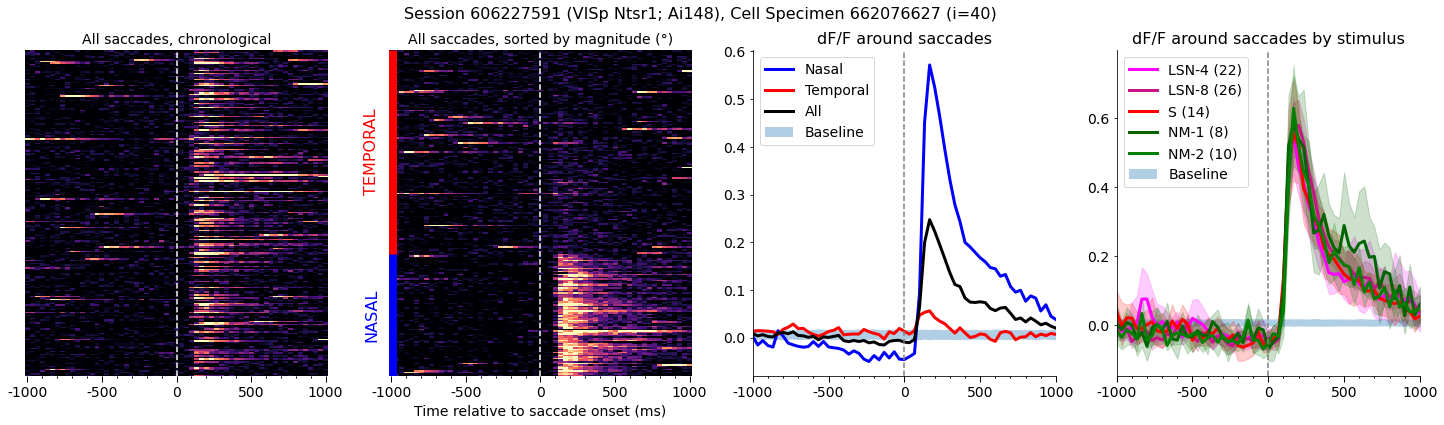

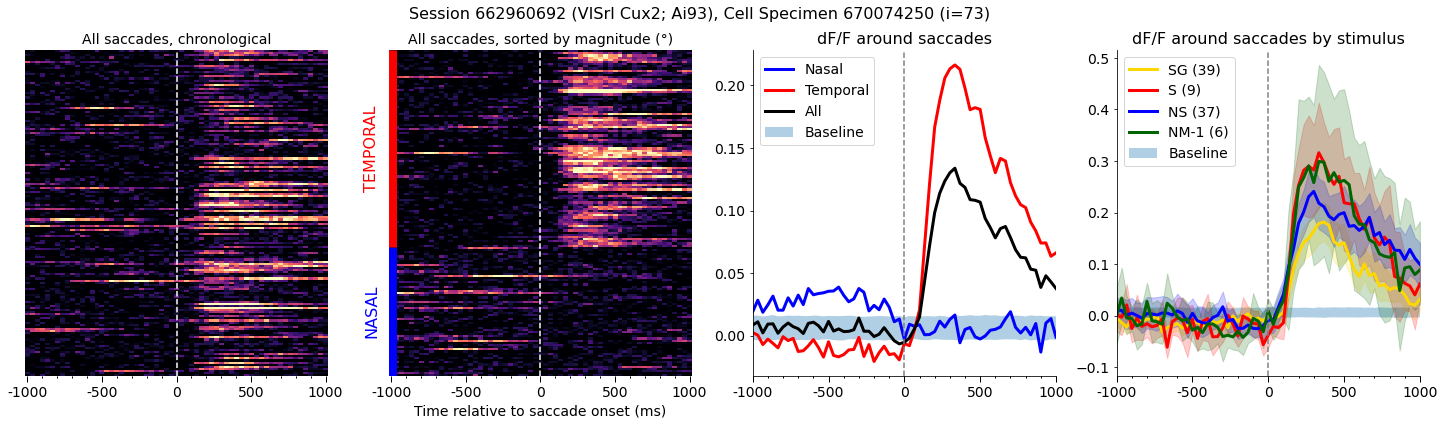

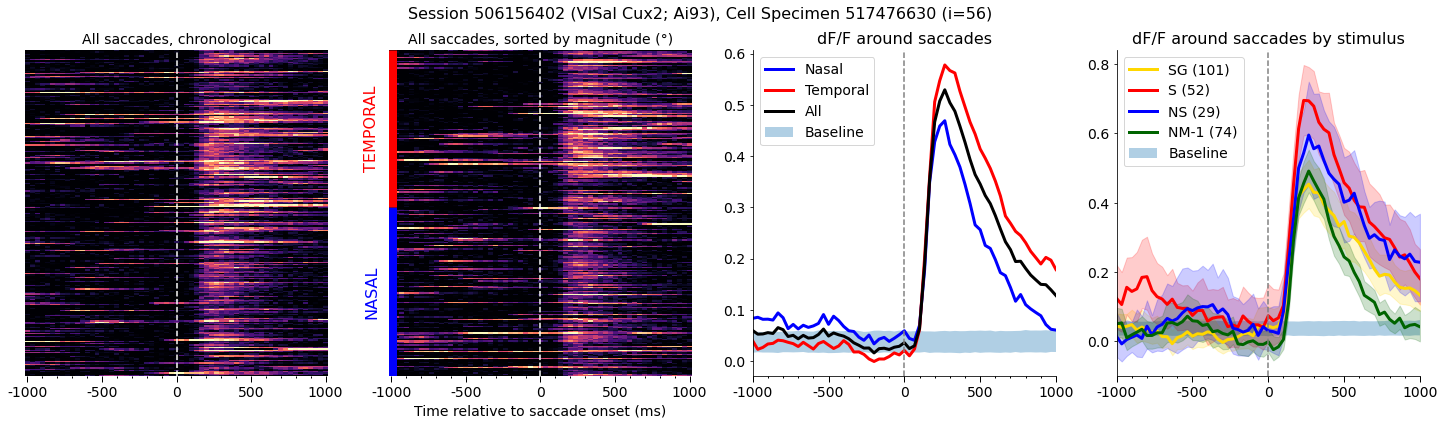

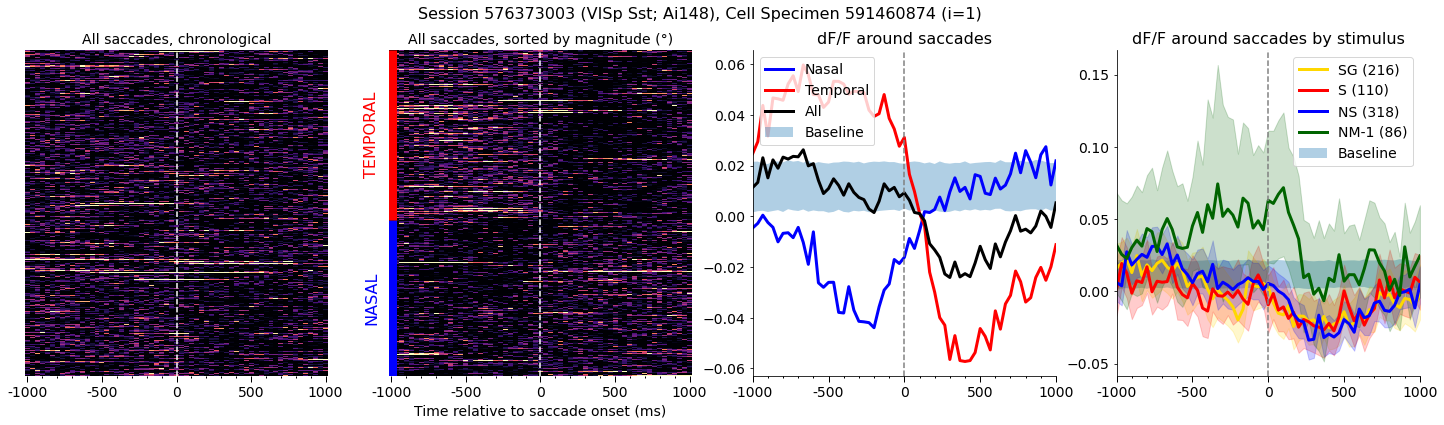

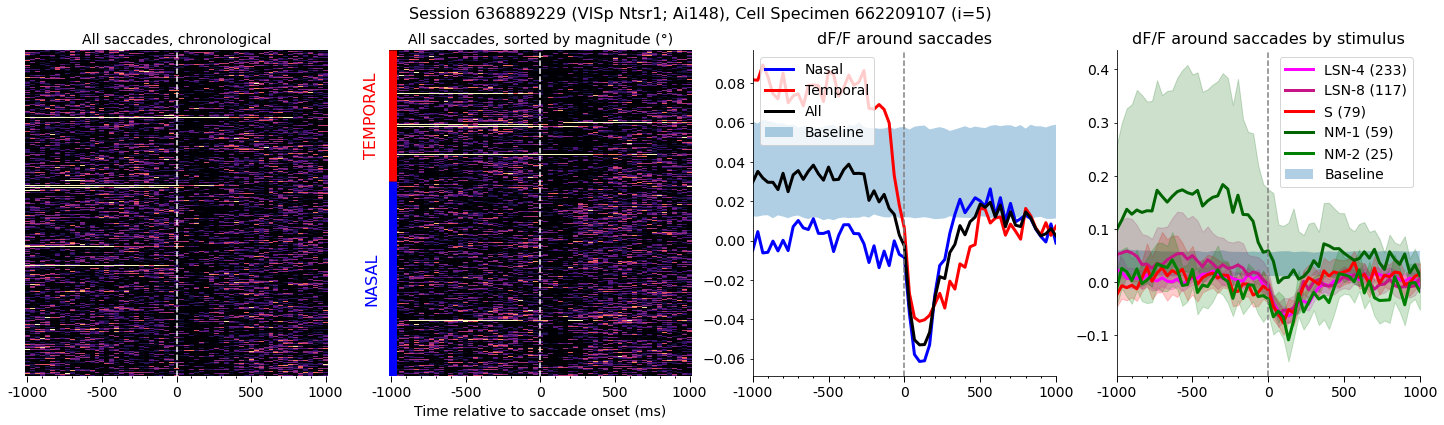

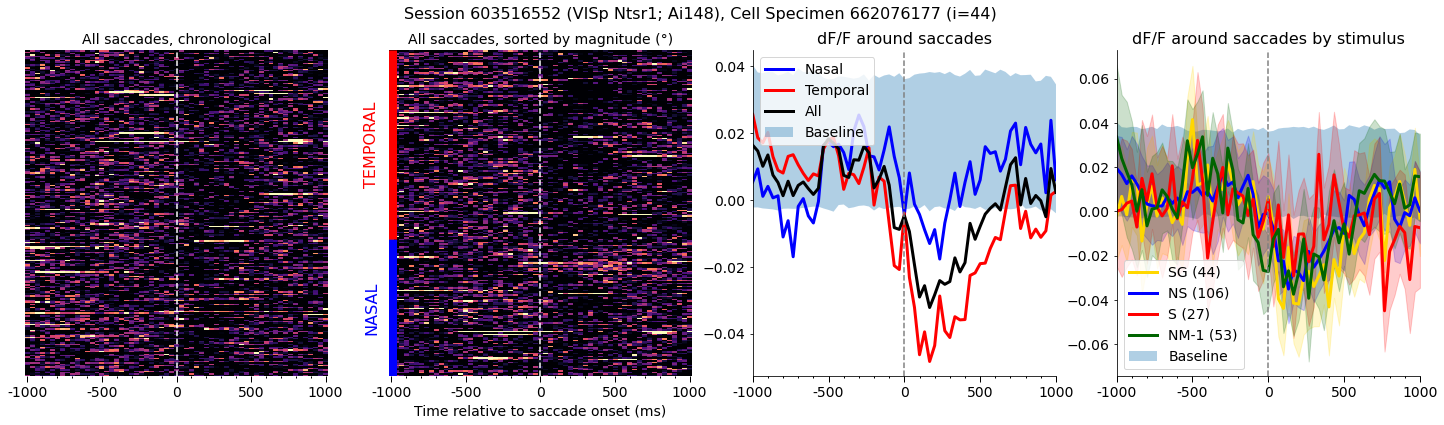

In [5]:
cells_to_plot = [(606227591, 40, 1, -1), (662960692, 73, 1, 1), (506156402, 56, 1, None), (576373003, 1, None, None), (636889229, 5, -1, None), (603516552, 44, -1, None)]

for session_id, cell_index, response_classification, ds in cells_to_plot:
# for session_id, cell_index in ((627823695, 2), (629789161, 6), (636889229, 5)):
    fig, filename = plot_sample_activity(session_id, cell_index, response_classification=response_classification, ds=ds, window_radius=30)
    # savefig(fig, filename, sub_dir="sample_cell_activity")
    # break